# Homework 2
### Marco Sicklinger, 03/2021


We first define some useful functions and classes.

In [1004]:
import torch as pt
from typing import List
from random import random, seed
seed(0)

We define, like taught in the laboratory, and `AvarageMeter()` class.

In [1005]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

We also provide a simple dataloader for better handling of data.

In [1006]:
class dataloader():
    """
    Dataloader for matrix-like inputs and vector-like outputs
    """

    def __init__(self, X, y):
        self._X = X.clone().detach()
        self._y = pt.tensor(y)

    def __len__(self):
        return self._X.shape[0]
    
    def __getitem__(self, index):
        return self._X[index,:], self._y[index]

In order to create the required data we define a function to use when symmetric vectors are required, `mirror_vectors`, and a function to create generic random vectors, `random_vector()`.  
In addition to that, we define a function, `symmetry()`, that allows us to determin if a vector satisfy the "mirror property".  
Finally, we defined a function that allows us to create the final dataset needed for the `dataloader()`.

In [1007]:
def mirror_vectors(n: int = 6):
    
    result = pt.empty((2**n, n))

    x = pt.arange((2**n))
    for i in range(n):
        m = 2**(i+1)
        result[:, i] = x%m < 2**i
    
    return result

In [1008]:
def symmetry(x):

    if len(x)%2 != 0: return 0

    for i in range(len(x)//2):
        if x[i] != x[len(x)-i-1]: 
            return 0
    return 1

In [1009]:
def data_creator(*data: List) -> List:

    result = []

    for item in data:
        result = result + item

    return result

We also defined a function needed to compute the accuracy. Since, this quantity is neede for each vector, we defined a function to compute it for each prediction associated to every vector passed with the `dataloader()`.

In [1010]:
def local_accuracy(y_hat, y):

    prediction = round(y_hat.item())
    if  prediction == y.item():
        return 1
    else:
        return 0

Then we define the multi-layer perceptron, the training functions and the test function, following the protocol used in class.

In [1011]:
class MultiLayerPerceptron(pt.nn.Module):

    def __init__(self):
        super().__init__()

        # Create members to simulate layers
        self._h_layer = pt.nn.Linear(in_features = 6, out_features = 2, bias = True)
        self._o_layer = pt.nn.Linear(in_features = 2, out_features = 1, bias = True)

    def forward(self, X):

        out = self._h_layer(X)
        out = pt.sigmoid(out)

        out = self._o_layer(out)
        out = pt.sigmoid(out)

        return out

In [1012]:
def train_epoch(model, data, loss_ft, optimizer, loss_meter, accuracy_meter):

    for x, y in data:

        optimizer.zero_grad()

        y_hat = model(x).ravel()

        loss = loss_ft(y_hat, y)

        loss.backward()

        optimizer.step()

        loss_meter.update(val=loss.item(), n=x.shape[0])

        acc = local_accuracy(y_hat, y)
        accuracy_meter.update(val=acc, n=x.shape[0])

In [1013]:
def train_model(model, data, loss_ft, optimizer, num_epochs): 
    model.train()

    losses = []

    for epoch in range(num_epochs):

        loss_meter = AverageMeter()

        accuracy_meter = AverageMeter()

        train_epoch(model, data, loss_ft, optimizer, loss_meter, accuracy_meter)

        losses.append(loss_meter.sum)

        #print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Accuracy: {accuracy_meter.avg}")
    
    return accuracy_meter.avg, losses

In [1014]:
def test_model(model, data, loss_ft=None):

    if loss_ft is not None:
        loss_meter = AverageMeter()
        accuracy_meter = AverageMeter()

    model.eval() 

    with pt.no_grad():
        for x, y in data:
            y_hat = model(x)
            loss = loss_ft(y_hat, y) if loss_ft is not None else None
            acc = local_accuracy(y_hat, y)
            if loss_ft is not None:
                loss_meter.update(loss.item(), x.shape[0])
            accuracy_meter.update(acc, x.shape[0])

    print(f"TESTING - loss {loss_meter.sum if loss_ft is not None else '--'} - Accuracy {accuracy_meter.avg}")

Here we create the data:

In [1015]:
X = mirror_vectors()

y = []
for i in range(len(X)):
    y.append(float(symmetry(X[i,:])))

and we define the dataloader and the loss function.

In [1016]:
data = dataloader(X,y)
loss_ft = pt.nn.MSELoss(reduction="sum")

We iteratively look for a model which can give us a total loss smaller or equal than $3.5$, values at which accuracy on the training should be satisfying.

In [1017]:
loss_threshold = 50
trial = 0

while(loss_threshold > 3.5):

    model = MultiLayerPerceptron()

    optimizer = pt.optim.SGD(model.parameters(), lr=0.1)

    acc, losses = train_model(model, data, loss_ft, optimizer, num_epochs)

    loss_threshold = losses[-1]

    trial += 1

    print("iteration {} -- loss {} -- accuracy {}".format(trial, loss_threshold, acc))

# print(f"Training completed - final loss {loss} -- Accuracy {acc}")

/home/macro/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
iteration 1 -- loss 41.89030350185931 -- accuracy 0.875
iteration 2 -- loss 40.271148218773305 -- accuracy 0.875
iteration 3 -- loss 40.71860184520483 -- accuracy 0.875
iteration 4 -- loss 42.14215796627104 -- accuracy 0.875


KeyboardInterrupt: 

We can inspect the weights by the following commands:

In [922]:
for par_name, par in model.state_dict().items():
    print(par_name,par,'\n')
    print('----------------')

_h_layer.weight tensor([[ -2.4997,  -0.2569, -12.9795,  12.9461,   0.4338,   2.4755],
        [  1.8697,  -0.7237,  -6.7383,   6.7925,   0.8795,  -1.9802]]) 

----------------
_h_layer.bias tensor([-0.0856,  1.4894]) 

----------------
_o_layer.weight tensor([[-10.8094,   5.2845]]) 

----------------
_o_layer.bias tensor([-4.0356]) 

----------------


In addition, it is possible tom plot the computations of the loss function for the best model found:

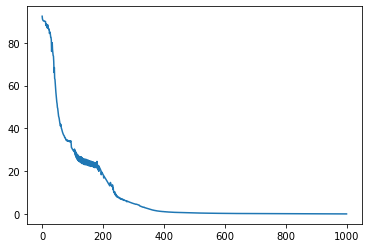

In [883]:
import matplotlib.pyplot as plt 
axis = [i for i in range(num_epochs)]
_ = plt.plot(axis,losses)
__ = plt.xlabel('epoch') 
___ = plt.ylabel('loss')

Finally we proceed with the test on some other data, created in the same way as before.

In [911]:
X1_test = mirror_vectors(15,)
X_test = data_creator(X1_test,X2_test)

y_test = []
for i in range(len(X_test)):
    y_test.append(float(symmetry(X_test[i])))

In [913]:
data_test = dataloader(X_test, y_test)

In [915]:
test_model(model, data_test, loss_ft=pt.nn.MSELoss(reduction="sum"))

TESTING - loss 24.296983845328214 - Accuracy 0.84
